In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!cp -R '/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/Dataset/' /content

In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/denoiser-inverse'

/content/drive/MyDrive/Colab Notebooks/Project/noise-reducer-ml/denoiser-inverse


In [4]:
!cp '/content/drive/MyDrive/train-001-300.tfrecord' /content/tfrecords/

In [5]:
import os
import tensorflow as tf
from IPython.display import Audio
# from denoiser.augment import augment

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def _parse_batch(record_batch, sample_rate, duration):
    n_samples = sample_rate * duration

    # Create a description of the features
    feature_description = {
        'noisy': tf.io.FixedLenFeature([n_samples], tf.float32),
        'clean': tf.io.FixedLenFeature([n_samples], tf.float32),
    }

    # Parse the input `tf.Example` proto using the dictionary above
    example = tf.io.parse_example(record_batch, feature_description)

    return example['noisy'], example['clean']

In [10]:
def get_dataset_from_tfrecords(tfrecords_dir='tfrecords', split='train',
                               batch_size=1, sample_rate=16000, duration=10,
                               n_epochs=10):
    if split not in ('train', 'test', 'validate'):
        raise ValueError("split must be either 'train', 'test' or 'validate'")

    # List all *.tfrecord files for the selected split
    pattern = os.path.join(tfrecords_dir, '{}*.tfrecord'.format(split))
    files_ds = tf.data.Dataset.list_files(pattern)

    # Disregard data order in favor of reading speed
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    files_ds = files_ds.with_options(ignore_order)

    # Read TFRecord files in an interleaved order
    ds = tf.data.TFRecordDataset(files_ds,
                                 compression_type='ZLIB',
                                 num_parallel_reads=AUTOTUNE)
    # ds = ds.shuffle(200, reshuffle_each_iteration=True)
    # Prepare batches
    ds = ds.batch(batch_size)

    # Parse a batch into a dataset of [audio, label] pairs
    ds = ds.map(lambda x: _parse_batch(x, sample_rate, duration))

    # Repeat the training data for n_epochs. Don't repeat test/validate splits.
    # if split == 'train':
    #     ds = ds.repeat(n_epochs)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
train_ds = get_dataset_from_tfrecords(tfrecords_dir='/content/tfrecords/')
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None))>


In [ ]:
path = "/content/tfrecords/outputs/"

In [24]:
import scipy.io.wavfile as wavfile

i = 0
for sample in train_ds:
  i += 1
  if i < 305:
    continue
  x = sample[0][0]
  y = sample[1][0]
  break
  # if i == 60:
  #   break
  # tf.io.write_file(path + f'{i}noisy.wav', tf.audio.encode_wav(tf.reshape(x,[len(x), 1]).numpy(), 48000))
  # tf.io.write_file(path + f'{i}clean.wav', tf.audio.encode_wav(tf.reshape(y,[len(x), 1]).numpy(), 48000))
  # i = i + 1

In [ ]:
!cp -R "/content/tfrecords/outputs" '/content/drive/MyDrive/tfrecords/outputs'

In [25]:
Audio(x.numpy(), rate=16000)

In [26]:
Audio(y.numpy(), rate=16000)

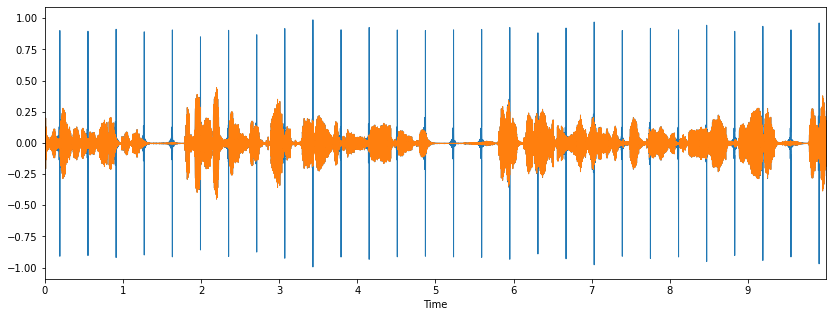

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x.numpy(), sr=48000)
librosa.display.waveplot(y.numpy(), sr=48000)

In [ ]:
rm /content/drive/MyDrive/tfrecords/outputs/*

In [ ]:
!ls | wc -l

600
